# MTA Data Processing and Interpreting Modules

The objective is to process the data csv by csv outputting a data frame which will then be appended onto.
The key data that will be scraped from the website, is the number of entries and exits. By station with time.

Could initially summarise it by day.

### Initializers:

In [3]:
# For compatibility between Python 2 and Python 3
from __future__ import print_function

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import pprint
from collections import defaultdict, namedtuple
import dateutil.parser
import datetime
from IPython.display import Image
from bs4 import *
import urllib
%matplotlib inline

## Scraper and File Importer
Scrape all links from the web:

In [44]:
#Find all the data files on MTA website
def mta_updater():
    prefix='http://web.mta.info/developers/'
    html='http://web.mta.info/developers/turnstile.html'
    #webv=urllib.request.urlopen(html) #Used in Python3
    webv=urllib.urlopen(html)
    soup=BeautifulSoup(webv,"lxml")
    tags = soup('a')
    linkslist=[]
    for tag in tags:
        h=tag.get('href',None)
        if h is not None:
            if h.startswith('data'):
                dates=re.findall('.[_]([0-9]+)',h)[0]
                linkslist.append((int(dates),prefix+h))
    return linkslist

In [ ]:
links=mta_updater()

for link in links:
    url_dest = link[1][-20:]
    urllib.urlretrieve(link[1], url_dest)

In [ ]:
with open('code/list_links_reduced1.csv','wb') as file:
    for line in links:
        file.write(line[1])
        file.write('\n')

## Data Pre-Processing
Pull data and summarise into daily data, setting the key as the station, regroup the number of entries and exits by date.
{station Name: {date1: [entries, exits] , date2=...}...}

The ouput of the function will be a Pandas file

### mta_daily_converter
This module takes a CSV file and splits it into a list of lists.

In [ ]:
def mta_daily_converter(csv_file):
    """This function imports the CSV files which 
    are fed to the function as a list of links to
    file locations and returns a dictionary"""
    lines = []
    #station_dict=defaultdict()
    with open(csv_file) as fhand:
        reader = csv.reader(fhand)
        for line in fhand:
            lines.append(line.strip().split(','))
    headers=lines.pop(0)
    assert headers == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'] 
    return headers, lines

### station_dict_maker
Take the list of lists from the CSV file and converts it to a dictionary with the form: {('C/A', 'Unit', 'SCP', 'STATION'): (time, entries,exits)...}.
The dates are converted into datetime objects.
The entries and exits are still the turnstiles raw counter number

In [249]:
def station_dict_maker(csv_file):
    # Create a named dictionary to better filter the data
    headers,lines = mta_daily_converter(csv_file)

    scheme = [heads.lower().replace('/','') for heads in headers]
    turn_data = namedtuple('turn_data', scheme)

    # Create a dictionary for the stations include
    # station reference and date plus entries and exits
    turn_datetime = namedtuple('turn_data',['time','entries','exits'])
    station_dict = defaultdict(list)

    entry_exits = []

    for line in lines:
        key = tuple(line[:4])
        vals = turn_data(*line)
        date = datetime.datetime.strptime(vals.date + vals.time, '%m/%d/%Y%X')
        entry,exits = int(vals.entries),int(vals.exits)
        val = turn_datetime(date,entry,exits)
        station_dict[key].append(val)
    # Confirm the rows are in order
    for rows in station_dict.values():
        rows.sort()
        assert rows == sorted(rows)
    return station_dict

### counts_by_day_by_station

This is to automatically produce an embedded dictionary where the first key is the station adn the second key is the date.  The entries and exits per time period are calcualated before being added to the total of that dictionary entry for a given station on a given day.

The code works in such a way that any data is recorded overnight between two days will be added to the previous days total.

In [398]:
def counts_by_day_bystation(csv_file):
    station_dict = station_dict_maker(csv_file)
    turn_counts=namedtuple("turn_counts",['time','entries','exits'])
    dates_turn_dict = defaultdict(dict)
    turn_counts_dict = defaultdict(list)
    for k,v in station_dict.items():
        station = k[-1]
        for i in range(len(v)):
            if dates_turn_dict[station].get(v[i].time.date(),0) == 0:
                entry = 0
                exit = 0
                val = turn_counts(v[i].time,entry,exit)
                dates_turn_dict[station][val.time.date()] = [entry,exit]
                if dates_turn_dict[station].get(v[i-1].time.date(),0) != 0:
                    # This adds the data occuring over night to previous day
                    dates_turn_dict[station][v[i-1].time.date()][0] += v[i].entries-v[i-1].entries
                    dates_turn_dict[station][v[i-1].time.date()][1] += v[i].exits-v[i-1].exits                    
            else:
                if i==0:
                    entry = v[i].entries-v[i].entries
                    exit = v[i].exits-v[i].exits    
                else:
                    entry = v[i].entries-v[i-1].entries
                    exit = v[i].exits-v[i-1].exits
                    if entry > 8000 or entry<0:
                        entry=np.nan
                    else:
                        entry =entry
                    if exit > 8000 or exit<0:
                        exit=np.nan
                    else:
                        exit=exit
                    val = turn_counts(v[i].time,entry,exit)
                    if val.time.time() == v[i-1].time.date():
                        dates_turn_dict[station][val.time.date()][0] += entry
                        dates_turn_dict[station][val.time.date()][1] += exit
                    else:
                        # This adds the data occuring over night to previous day
                        dates_turn_dict[station][v[i-1].time.date()][0] += entry
                        dates_turn_dict[station][v[i-1].time.date()][1] += exit
    return dates_turn_dict

### csv_processor
This takes the processed CSV file from counts_by_day_bystation and converts it into a pandas dataframe.

In [399]:
def csv_processor(csv_file):
    processed_csv=counts_by_day_bystation(csv_file)
    # Remap to two data frames the entry and exits
    entry_dict = defaultdict(dict)
    exit_dict = defaultdict(dict)

    for k,v in processed_csv.items():
        for k2,v2 in v.items():
            entry_dict[k][k2] = v2[0]
            exit_dict[k][k2] = v2[1]
    
    df_entry = pd.DataFrame.from_dict(entry_dict, orient='columns')
    df_exit = pd.DataFrame.from_dict(exit_dict, orient='columns') 
    return (df_entry, df_exit)



Below function is the master function running all the above modules.  This takes as an input a list of csv file locations and runs the csv_processor along with all the above modules in order to return a dataframe which it then concatanates onto the previous dataframe.
Each CSV file generally contains 7 days of data which then means each data frame is 7 rows with columns adding up to the station names.

In [433]:
# Run through each csv file and make a pandas dataframe
count=0
for ind,links in enumerate(links_lst):
    df_entry,df_exit = csv_processor(links)
    if ind ==0:
        df_master_entry = df_entry
        df_master_exit = df_exit
    else:
        df_master_entry = pd.concat([df_entry,df_master_entry],axis=0,ignore_index=False)
        df_master_exit = pd.concat([df_exit,df_master_exit],axis=0,ignore_index=False)
    count+=1
    
    if count%50 == 0:
        name1='entry_links_upto%d.csv' %(count)
        name2='entry_links_upto%d.csv' %(count)
        df_master_entry.to_csv(name1, sep=',')
        df_master_exit.to_csv(name2, sep=',')
        print('written csv file')
    
    print(count)

#Write to CSV file
df_master_entry.to_csv('entries_20150124.csv', sep=',')
df_master_exit.to_csv('exits_20150124.csv', sep=',')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
written csv file
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
written csv file
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


KeyboardInterrupt: 

In [59]:
# Set index as a datetime object
df_master_entry.index=pd.to_datetime(df_master_entry.index)
df_master_entry.index=pd.to_datetime(df_master_entry.index)
df_master_entry.reset_index()

,index,1 AV,1 AVE,103 ST,103 ST-CORONA,104 ST,110 ST,110 ST-CATHEDRL,110 ST-CPN,111 ST,...,WILSON AV,WILSON AVE,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,WOODLAWN ROAD,WORLD TRADE CTR,YORK ST,ZEREGA AV,ZEREGA AVE
0,2015-01-24,NaN,19190.0,20530.0,13926.0,NaN,7293.0,9786.0,6137.0,8992.0,...,NaN,3049.0,2989.0,14833.0,NaN,3412.0,4120.0,4021,NaN,NaN
1,2015-01-25,NaN,14603.0,17373.0,10740.0,NaN,5665.0,8263.0,5325.0,7242.0,...,NaN,2526.0,2484.0,13350.0,NaN,2936.0,3622.0,3467,NaN,NaN
2,2015-01-26,NaN,19753.0,29756.0,16538.0,NaN,10797.0,11643.0,8069.0,11679.0,...,NaN,3922.0,7068.0,22127.0,NaN,6073.0,9948.0,7694,NaN,NaN
3,2015-01-27,NaN,9047.0,11334.0,6095.0,NaN,3745.0,4616.0,3395.0,4214.0,...,NaN,1445.0,1836.0,6616.0,NaN,954.0,2078.0,2036,NaN,NaN
4,2015-01-28,NaN,24485.0,34692.0,19771.0,NaN,12511.0,13795.0,9333.0,13359.0,...,NaN,4504.0,8030.0,26693.0,NaN,7384.0,12003.0,9305,NaN,NaN
5,2015-01-29,NaN,25757.0,35808.0,20005.0,NaN,12774.0,14319.0,9879.0,14021.0,...,NaN,4755.0,8299.0,27333.0,NaN,7714.0,12812.0,9932,NaN,NaN
6,2015-01-30,NaN,24759.0,32412.0,19758.0,NaN,12606.0,13349.0,9706.0,13409.0,...,NaN,4525.0,7568.0,25241.0,NaN,7542.0,12239.0,8544,NaN,NaN
7,2015-01-31,NaN,17200.0,22070.0,14308.0,NaN,8307.0,10346.0,0.0,9190.0,...,NaN,3169.0,3506.0,16744.0,NaN,4405.0,4806.0,4280,NaN,NaN
8,2015-02-01,NaN,12896.0,17934.0,10979.0,NaN,6009.0,8335.0,4147.0,7212.0,...,NaN,2404.0,2555.0,12930.0,NaN,3159.0,3231.0,3324,NaN,NaN
9,2015-02-02,NaN,21668.0,31220.0,12722.0,NaN,10959.0,12058.0,8050.0,10003.0,...,NaN,3955.0,7341.0,22655.0,NaN,5304.0,11190.0,8422,NaN,NaN


In [61]:
pd.melt(df_master_entry, value_vars=list(df_master_entry.columns)[1:], id_vars='index')



,index,variable,value
0,NaN,1 AVE,19190.0
1,NaN,1 AVE,14603.0
2,NaN,1 AVE,19753.0
3,NaN,1 AVE,9047.0
4,NaN,1 AVE,24485.0
5,NaN,1 AVE,25757.0
6,NaN,1 AVE,24759.0
7,NaN,1 AVE,17200.0
8,NaN,1 AVE,12896.0
9,NaN,1 AVE,21668.0


In [ ]:
df_master_entry

In [57]:
list(df_master_entry.columns)


['1 AV',
 '1 AVE',
 '103 ST',
 '103 ST-CORONA',
 '104 ST',
 '110 ST',
 '110 ST-CATHEDRL',
 '110 ST-CPN',
 '111 ST',
 '116 ST',
 '116 ST-COLUMBIA',
 '121 ST',
 '125 ST',
 '135 ST',
 '137 ST CITY COL',
 '137 ST-CITY COL',
 '138 ST-3 AVE',
 '138 ST-GR CONC',
 '138/GRAND CONC',
 '14 ST',
 '14 ST-6 AVE',
 '14 ST-UNION SQ',
 '145 ST',
 '148 ST-LENOX',
 '149 ST-3 AVE',
 '149 ST-GR CONC',
 '149/GRAND CONC',
 '14TH STREET',
 '15 ST-PROSPECT',
 '155 ST',
 '157 ST',
 '161 ST-YANKEE',
 '161/YANKEE STAD',
 '163 ST-AMSTERDM',
 '167 ST',
 '168 ST',
 '168 ST-BROADWAY',
 '169 ST',
 '170 ST',
 '174 ST',
 '174-175 ST',
 '174-175 STS',
 '175 ST',
 '176 ST',
 '18 AV',
 '18 AVE',
 '18 ST',
 '181 ST',
 '182-183 ST',
 '182-183 STS',
 '183 ST',
 '190 ST',
 '191 ST',
 '2 AV',
 '2 AVE',
 '20 AV',
 '20 AVE',
 '207 ST',
 '21 ST',
 '21 ST-QNSBRIDGE',
 '215 ST',
 '219 ST',
 '22 AVE-BAY PKY',
 '225 ST',
 '23 ST',
 '23 ST-5 AVE',
 '23 ST-6 AVE',
 '231 ST',
 '233 ST',
 '238 ST',
 '242 ST',
 '25 AV',
 '25 AVE',
 '25 ST'

### Reload the data if required from existing csv files

In [49]:
"""Reload from CSV"""

df_master_entry = pd.read_csv('entries_20150124.csv',sep=',',index_col=0)
df_master_exit = pd.read_csv('exits_20150124.csv',sep=',',index_col=0)
# Set index as a datetime object
df_master_entry.index=pd.to_datetime(df_master_entry.index)
df_master_exit.index=pd.to_datetime(df_master_exit.index)

Process the data into an entries and exits dataframe with means and sort them.

In [39]:
entry_by_year=df_master_entry.resample('A').apply('mean')
exit_by_year = df_master_exit.resample('A').apply('mean')

In [40]:
entries = entry_by_year.T.sort_values('2017-12-31 00:00:00',ascending=False)

In [41]:
exits = exit_by_year.T.sort_values('2017-12-31 00:00:00',ascending=False)
entries = entry_by_year.T.sort_values('2017-12-31 00:00:00',ascending=False)

Plot the graphs for entries and exits

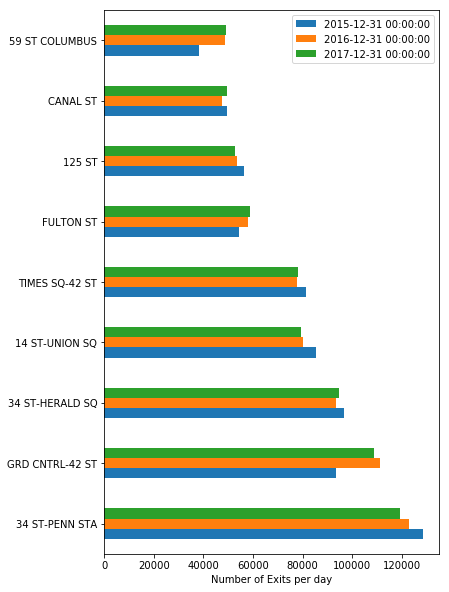

In [19]:
# Exits plot
h=exits[1:10].iloc[::,:]
ax=h.plot.barh(stacked=False, figsize=(6,10))
ax.set_xlabel('Number of Exits per day')

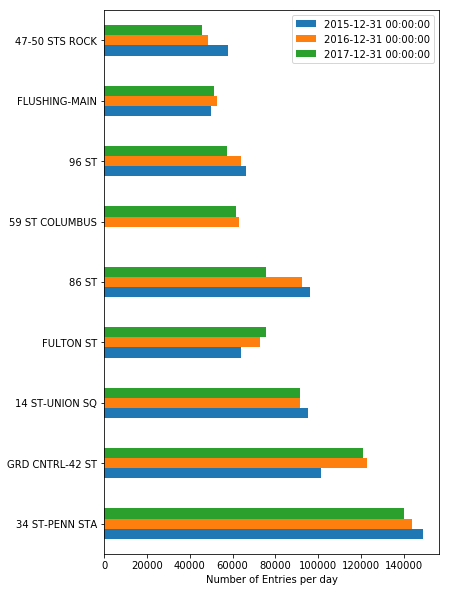

In [42]:
# Entries plot
g=entries[1:10].iloc[::,:]
ax=g.plot.barh(stacked=False, figsize=(6,10))
ax.set_xlabel('Number of Entries per day')

In [29]:
col1=g.round(decimals=0)['2017-12-31 00:00:00']
col2=h.round(decimals=0)['2017-12-31 00:00:00']

In [34]:
dff=pd.concat([col1, col2],axis=1)
dff

,2017-12-31 00:00:00,2017-12-31 00:00:00
125 ST,NaN,52754.0
14 ST-UNION SQ,91474.0,79378.0
34 ST-HERALD SQ,NaN,94726.0
34 ST-PENN STA,140003.0,119317.0
47-50 STS ROCK,45842.0,NaN
59 ST COLUMBUS,61689.0,49200.0
86 ST,75546.0,NaN
96 ST,57304.0,NaN
CANAL ST,NaN,49426.0
FLUSHING-MAIN,51412.0,NaN


In [ ]:
dff